<a href="https://colab.research.google.com/github/gpfer/projektR/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import transforms

In [40]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dohvati klase i ground truth

In [41]:
import base64
import requests

labels_cls = "https://raw.githubusercontent.com/gpfer/projektR/main/dataset/klasifikacija.csv"
labels_cls = requests.get(labels_cls)
labels_cls = labels_cls.text

labels_gt = "https://raw.githubusercontent.com/gpfer/projektR/main/dataset/cube%2B_gt.txt"
labels_gt = requests.get(labels_gt)
labels_gt = labels_gt.text

Obrada labela

In [42]:
import numpy as np
import io

labels_cls = labels_cls.split('\n')

nd = []
for line in labels_cls[1:1708]:
    line = line.split(',')
    num = int(line[0])
    val = line[1] + '-' + line[2]
    if val.startswith('in'):
        val = 'in'
    nd.append([num, val])

data = np.array(nd)

cats = np.unique(data[:, 1])
print(cats)
new_data = []
for d in data:
  new_data.append(np.where(cats == d[1])[0][0])
labels_cls = torch.LongTensor(new_data)
labels_cls

['in' 'out-day' 'out-night']


tensor([1, 1, 1,  ..., 2, 1, 1])

In [43]:
labels_gt = labels_gt.split('\n')

nd = []
for line in labels_gt[:-1]:
    gt = []
    line = line.split(' ')
    gt.append(float(line[0]))
    gt.append(float(line[1]))
    gt.append(float(line[2]))

    nd.append(gt)

labels_gt = torch.FloatTensor(nd)
labels_gt

tensor([[0.1624, 0.4533, 0.3844],
        [0.2027, 0.4695, 0.3278],
        [0.2040, 0.4714, 0.3246],
        ...,
        [0.4779, 0.4416, 0.0806],
        [0.2037, 0.4708, 0.3254],
        [0.3866, 0.4606, 0.1528]])

Ucitavanje slika

In [44]:
from PIL import Image

root = "/content/drive/My Drive/PNG"

train_images = []
test_images = []

for i in range(1, 1708):
    name = str(i) + ".PNG"
    img = Image.open(root + '/' + name)
    basewidth = 128
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    arr = transforms.ToTensor()(img)
    arr = arr - 2048 / 65536
    arr[arr<0] = 0
    if i < int(0.8*1707):
        train_images.append(arr)
    else:
        test_images.append(arr)
print()
train_images = torch.stack(train_images)
test_images = torch.stack(test_images)
train_images
test_images

tensor([[[[9.0319e-02, 9.0319e-02, 9.0319e-02,  ..., 4.7181e-02,
           5.1103e-02, 5.1103e-02],
          [9.0319e-02, 9.0319e-02, 9.0319e-02,  ..., 4.7181e-02,
           4.7181e-02, 5.1103e-02],
          [9.0319e-02, 9.0319e-02, 9.0319e-02,  ..., 4.7181e-02,
           4.7181e-02, 4.7181e-02],
          ...,
          [7.8554e-02, 7.8554e-02, 7.8554e-02,  ..., 1.2255e-04,
           1.2255e-04, 1.2255e-04],
          [8.2475e-02, 8.2475e-02, 8.2475e-02,  ..., 1.2255e-04,
           1.2255e-04, 1.2255e-04],
          [8.2475e-02, 8.2475e-02, 8.2475e-02,  ..., 1.2255e-04,
           1.2255e-04, 4.0441e-03]],

         [[1.0600e-01, 1.0600e-01, 1.0600e-01,  ..., 4.3260e-02,
           4.3260e-02, 4.7181e-02],
          [1.0600e-01, 1.0600e-01, 1.0600e-01,  ..., 4.3260e-02,
           4.3260e-02, 4.3260e-02],
          [1.0600e-01, 1.0600e-01, 1.0600e-01,  ..., 4.3260e-02,
           4.3260e-02, 4.3260e-02],
          ...,
          [9.4240e-02, 9.4240e-02, 9.8162e-02,  ..., 1.2255

In [45]:
train_labels_cls = labels_cls[:int(0.8*len(labels_cls))-1]
test_labels_cls = labels_cls[int(0.8*len(labels_cls))-1:]

train_labels_gt = labels_gt[:int(0.8*len(labels_gt))-1]
test_labels_gt = labels_gt[int(0.8*len(labels_gt))-1:]

In [46]:
train_dataset_cls = TensorDataset(train_images, train_labels_cls)
test_dataset_cls = TensorDataset(test_images, test_labels_cls)

train_dataset_gt = TensorDataset(train_images, train_labels_gt)
test_dataset_gt = TensorDataset(test_images, test_labels_gt)

train_loader_cls = DataLoader(train_dataset_cls, batch_size=64, shuffle=True)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=64, shuffle=True)

train_loader_gt = DataLoader(train_dataset_gt, batch_size=64, shuffle=True)
test_loader_gt = DataLoader(test_dataset_gt, batch_size=64, shuffle=True)

# Teniranje klasifikatora

Keiranje modela za klasifikaciju

In [85]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5)

    self.fc1 = nn.Linear(5376, 800)
    self.fc2 = nn.Linear(800, 400)
    self.fc3 = nn.Linear(400, 100)
    self.fc4 = nn.Linear(100, 3)

    self.batch = nn.BatchNorm1d(800)
    
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = x.view(-1, 5376)
    x = self.fc1(x)
    x = self.relu(x)

    x = self.batch(x)

    x = self.fc2(x)
    x = self.relu(x)

    x = self.fc3(x)
    x = self.relu(x)

    x = self.fc4(x)
    x = self.relu(x)

    return F.log_softmax(x, dim=1)

In [86]:
n_epochs = 10
learning_rate = 0.00005
device = 'cpu'

Funkcije za treniranje i evaluaciju klasifikacije

In [49]:
def train_step_cls(network, train_data, epoch, device):
  losses = []
  counter = []

  network.train()
  for idx, (data, target) in enumerate(train_data):
    data = data.to(device)
    target = target.to(device)

    network.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if idx % 5 == 0:
      print('Train Epoch: {:2d}, ({:2.0f}%), Loss: {:.5f}'.format(
          epoch, 100*idx*64/len(train_data.dataset), loss
      ))
      losses.append(loss)
      counter.append(idx*64 + (epoch-1)*len(train_data.dataset))

  return losses, counter

In [50]:
def test_cls(network, test_data, device):
  network.eval()

  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_data:
      data = data.to(device)
      target = target.to(device)

      output = network(data)
      loss += F.nll_loss(output, target, reduction="sum").item()
      prediction = output.data.max(1, keepdim=True)[1]
      correct += prediction.eq(target.data.view_as(prediction)).sum()

  loss /= len(test_data.dataset)
  accuracy = 100 * correct / len(test_data.dataset)

  print('\nTest loss: {:.3f}, Accuracy: {:4d}/{:4d} ({:2.2f}%)'.format(
      loss, correct, len(test_data.dataset), accuracy
  ))

  return loss, accuracy

In [51]:
def train_cls(network, train_data, test_data, device='cuda'):
  test_loss = []
  test_acc = []
  train_loss = []
  counter = []

  # testiramo pocetni model
  loss_t, acc_t = test_cls(network, test_data, device)
  test_loss.append(loss_t)
  test_acc.append(acc_t)

  for epoch in range(1, n_epochs+1):
    # korak i test
    loss, cnt = train_step_cls(network, train_data, epoch, device)
    loss_t, acc_t = test_cls(network, test_data, device)

    test_loss.append(loss_t)
    test_acc.append(acc_t)
    train_loss.append(loss)
    counter.append(cnt)

  return test_loss, test_acc, train_loss, counter

Treniranje modela

In [105]:
klasifikacija = Net().to(device)
optimizer = optim.Adam(klasifikacija.parameters(), lr=learning_rate)

In [106]:
test_loss, test_acc, train_loss, counter = train_cls(klasifikacija, train_loader_cls, test_loader_cls, device)


Test loss: 1.112, Accuracy:   60/ 343 (17.49%)
Train Epoch:  1, ( 0%), Loss: 1.10714
Train Epoch:  1, (23%), Loss: 1.10332
Train Epoch:  1, (47%), Loss: 1.09525
Train Epoch:  1, (70%), Loss: 1.07984
Train Epoch:  1, (94%), Loss: 1.02648

Test loss: 1.109, Accuracy:   60/ 343 (17.49%)
Train Epoch:  2, ( 0%), Loss: 1.00917
Train Epoch:  2, (23%), Loss: 0.97381
Train Epoch:  2, (47%), Loss: 0.92613
Train Epoch:  2, (70%), Loss: 0.92887
Train Epoch:  2, (94%), Loss: 0.88687

Test loss: 1.061, Accuracy:  182/ 343 (53.06%)
Train Epoch:  3, ( 0%), Loss: 0.82890
Train Epoch:  3, (23%), Loss: 0.82020
Train Epoch:  3, (47%), Loss: 0.78996
Train Epoch:  3, (70%), Loss: 0.73484
Train Epoch:  3, (94%), Loss: 0.70194

Test loss: 0.920, Accuracy:  263/ 343 (76.68%)
Train Epoch:  4, ( 0%), Loss: 0.66021
Train Epoch:  4, (23%), Loss: 0.66643
Train Epoch:  4, (47%), Loss: 0.57201
Train Epoch:  4, (70%), Loss: 0.52239
Train Epoch:  4, (94%), Loss: 0.46472

Test loss: 0.671, Accuracy:  310/ 343 (90.38%)


In [107]:
torch.save(klasifikacija.state_dict(), './klasifikacija.pth')

Vizualizacija treninga

In [108]:
import matplotlib.pyplot as plt

counter = np.array(counter).flatten()
train_loss = np.array(train_loss).flatten()


No handles with labels found to put in legend.


Text(0.5, 0, 'Steps')

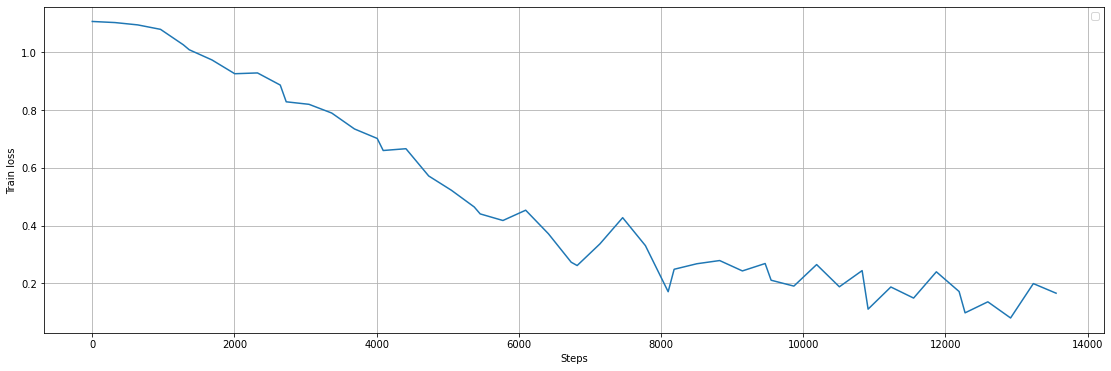

In [109]:
plt.figure(figsize=(19, 6))

plt.plot(counter, train_loss)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

No handles with labels found to put in legend.


Text(0.5, 0, 'Steps')

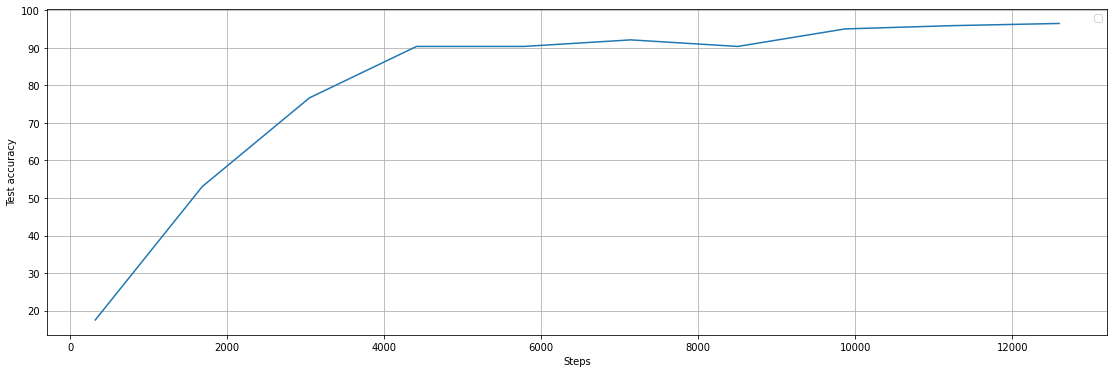

In [110]:
test_acc = np.array(test_acc).flatten()
plt.figure(figsize=(19, 6))

plt.plot(counter[1::5], test_acc[1:])

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Steps")

In [111]:
confusion_matrix = torch.zeros(3, 3)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader_cls):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = klasifikacija(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(cats)
print(confusion_matrix)

['in' 'out-day' 'out-night']
tensor([[ 52.,   7.,   1.],
        [  4., 270.,   0.],
        [  0.,   0.,   9.]])


# Procjena osvjetljenja

Kreiranje modela za procjenu osvjetljenja

In [112]:
class Net(nn.Module):
  def __init__(self, klas):
    super(Net, self).__init__()

    self.klas = klas

    self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5)

    self.fc1 = nn.Linear(5376, 800)
    self.fc2 = nn.Linear(800, 400)
    self.fc3 = nn.Linear(400, 50)
    self.fc4 = nn.Linear(50 + 3, 3)

    self.batch = nn.BatchNorm1d(800)
    
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    self.klas.eval()
    k = None
    with torch.no_grad():
        k = self.klas(x)

    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = x.view(-1, 5376)
    x = self.fc1(x)
    x = self.relu(x)

    x = self.batch(x)

    x = self.fc2(x)
    x = self.relu(x)

    x = self.fc3(x)
    x = self.relu(x)

    x1 = x.view(x.size(0), -1)
    x2 = k.view(k.size(0), -1)
    
    x = torch.cat((x1, x2), dim=1)

    x = self.fc4(x)
    x = self.relu(x)

    return x

In [113]:
n_epochs = 10
learning_rate = 0.00005
device = 'cpu'

Funkcije za treniranje

In [60]:
def train_step_gt(network, train_data, epoch, device):
  losses = []
  counter = []

  network.train()
  for idx, (data, target) in enumerate(train_data):
    data = data.to(device)
    target = target.to(device)

    network.zero_grad()
    output = network(data)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()

    if idx % 5 == 0:
      print('Train Epoch: {:2d}, ({:2.0f}%), Loss: {:.5f}'.format(
          epoch, 100*idx*64/len(train_data.dataset), loss
      ))
      losses.append(loss)
      counter.append(idx*64 + (epoch-1)*len(train_data.dataset))

  return losses, counter

In [61]:
def test_gt(network, test_data, device):
  network.eval()

  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_data:
      data = data.to(device)
      target = target.to(device)

      output = network(data)
      loss += F.mse_loss(output, target, reduction="sum").item()
      prediction = output.data.max(1, keepdim=True)[1]

  loss /= len(test_data.dataset)

  print('\nTest loss: {:.3f}'.format(
      loss
  ))

  return loss

In [62]:
def train_gt(network, train_data, test_data, device='cuda'):
  test_loss = []
  train_loss = []
  counter = []

  # testiramo pocetni model
  loss_t = test_gt(network, test_data, device)
  test_loss.append(loss_t)

  for epoch in range(1, n_epochs+1):
    # korak i test
    loss, cnt = train_step_gt(network, train_data, epoch, device)
    loss_t = test_gt(network, test_data, device)

    test_loss.append(loss_t)
    train_loss.append(loss)
    counter.append(cnt)

  return test_loss, train_loss, counter

In [114]:
procjena = Net(klasifikacija).to(device)
optimizer = optim.Adam(procjena.parameters(), lr=learning_rate)

In [115]:
test_loss, train_loss, counter = train_gt(procjena, train_loader_gt, test_loader_gt, device)


Test loss: 1.057
Train Epoch:  1, ( 0%), Loss: 0.40996
Train Epoch:  1, (23%), Loss: 0.35431
Train Epoch:  1, (47%), Loss: 0.29128
Train Epoch:  1, (70%), Loss: 0.22275
Train Epoch:  1, (94%), Loss: 0.18221

Test loss: 0.990
Train Epoch:  2, ( 0%), Loss: 0.18753
Train Epoch:  2, (23%), Loss: 0.12579
Train Epoch:  2, (47%), Loss: 0.12256
Train Epoch:  2, (70%), Loss: 0.10407
Train Epoch:  2, (94%), Loss: 0.07703

Test loss: 0.814
Train Epoch:  3, ( 0%), Loss: 0.07462
Train Epoch:  3, (23%), Loss: 0.06310
Train Epoch:  3, (47%), Loss: 0.05517
Train Epoch:  3, (70%), Loss: 0.06057
Train Epoch:  3, (94%), Loss: 0.03518

Test loss: 0.532
Train Epoch:  4, ( 0%), Loss: 0.05760
Train Epoch:  4, (23%), Loss: 0.05546
Train Epoch:  4, (47%), Loss: 0.03337
Train Epoch:  4, (70%), Loss: 0.02981
Train Epoch:  4, (94%), Loss: 0.02362

Test loss: 0.100
Train Epoch:  5, ( 0%), Loss: 0.03047
Train Epoch:  5, (23%), Loss: 0.02627
Train Epoch:  5, (47%), Loss: 0.02797
Train Epoch:  5, (70%), Loss: 0.0258

In [116]:
torch.save(procjena.state_dict(), './procjena.pth')

No handles with labels found to put in legend.


Text(0.5, 0, 'Steps')

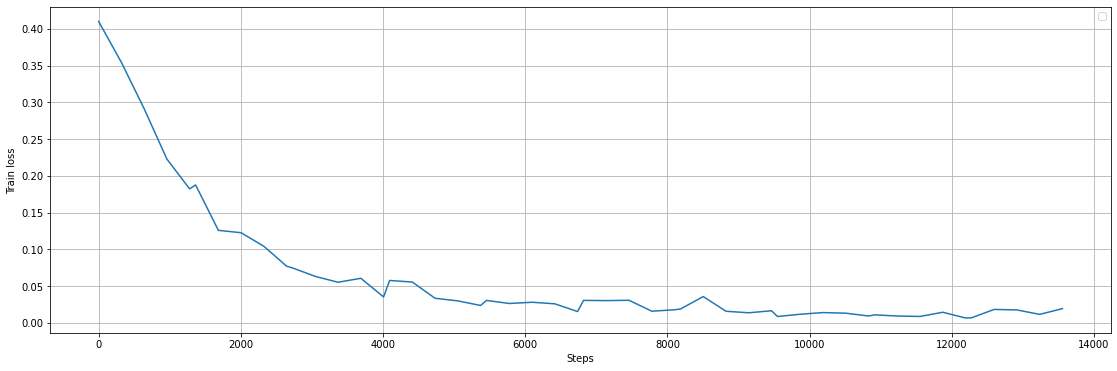

In [117]:
counter = np.array(counter).flatten()
train_loss = np.array(train_loss).flatten()

plt.figure(figsize=(19, 6))

plt.plot(counter, train_loss)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")